In [1]:
import pyedflib
import matplotlib.pyplot as plt
import numpy as np

import scipy.io.wavfile as wavfile
import os

#### 读取一个EDF文件进行测试，找出
#### PSG-Audio a scored polysomnography dataset
#### 中提到的 Ambient microphone（环境麦克风）
#### 放置在病人头部上方约1米处，记录房间内的呼吸声、打鼾声等。

In [2]:
edf_path = './data/edf/00000995-100507[001].edf'

from check_edf_channel import check_edf_channel_auto

check_edf_channel_auto(edf_path)

共有 20 个通道:
1. EEG A1-A2
2. EEG C3-A2
3. EEG C4-A1
4. EOG LOC-A2
5. EOG ROC-A2
6. EMG Chin
7. Leg 1
8. Leg 2
9. ECG I
10. RR
11. Snore
12. Flow Patient
13. Flow Patient
14. Effort THO
15. Effort ABD
16. SpO2
17. Body
18. PulseRate
19. Mic
20. Tracheal


#### Mic可能就是环境麦克风
#### 原文中提到这两个通道被命名成'Tracheal' and 'Microphone'
#### 验证采样率和可视化波形，看看是否是环境麦克风

In [3]:
f = pyedflib.EdfReader(edf_path)
# 获取所有通道标签
labels = f.getSignalLabels()

mic_index = labels.index("Mic")

# 获取该通道的采样率与样本总数
sample_rate = f.getSampleFrequency(mic_index)
n_samples = f.getNSamples()[mic_index]
print(f"Channel 'Mic' — Sample rate: {sample_rate} Hz, Samples: {n_samples}")

Channel 'Mic' — Sample rate: 48000.0 Hz, Samples: 172800000


#### 确认是声音信号

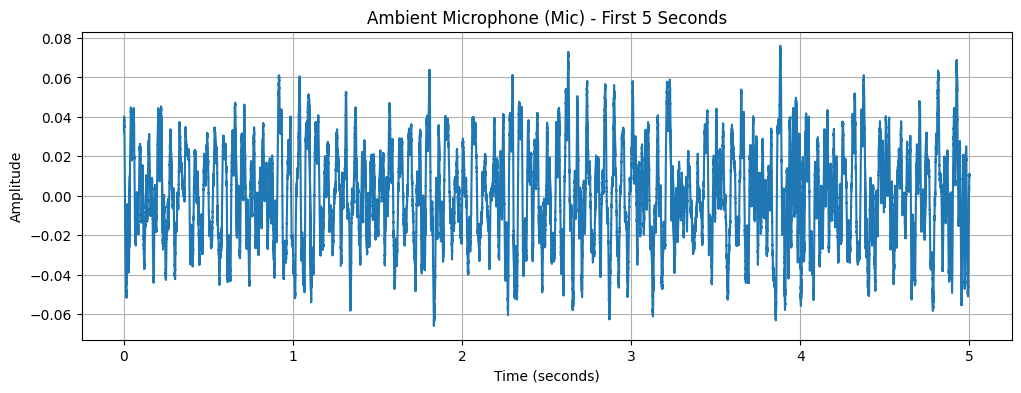

In [4]:
# 设置要可视化的时长（秒）
duration_sec = 5
samples_to_read = int(sample_rate * duration_sec)
samples_to_read = min(samples_to_read, n_samples)

# 读取 Mic 通道信号
signal = f.readSignal(mic_index)[:samples_to_read]

# 构建时间轴并画图
time_axis = np.linspace(0, samples_to_read / sample_rate, samples_to_read)
plt.figure(figsize=(12, 4))
plt.plot(time_axis, signal)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Ambient Microphone (Mic) - First 5 Seconds")
plt.grid(True)
plt.show()

f.close()


信号前 3600 秒的采样值（共 360000 个点）：


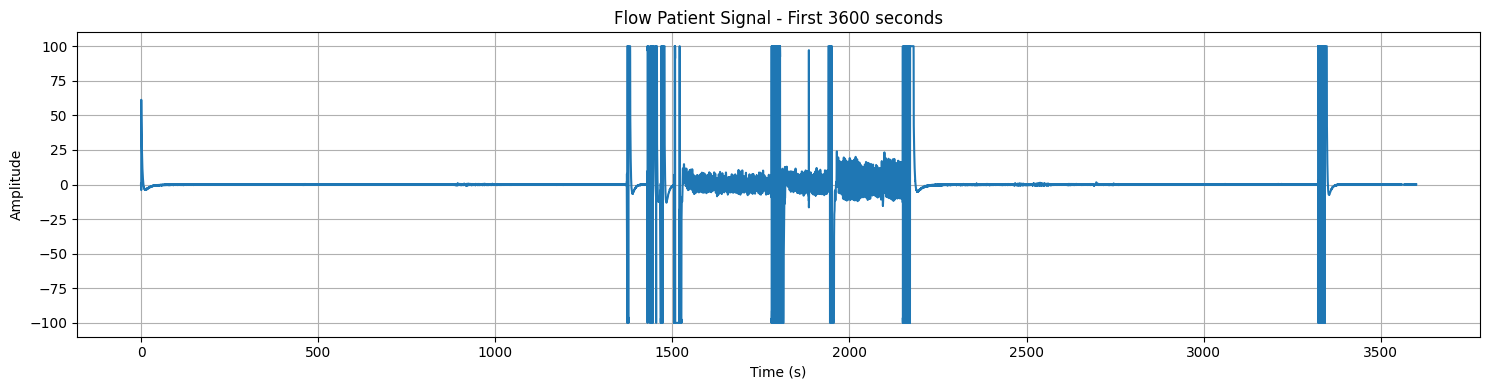

In [8]:
f = pyedflib.EdfReader(edf_path)

# 获取所有通道标签
labels = f.getSignalLabels()

flow_index = labels.index("Flow Patient")

# 获取采样率和信号数据
fs = f.getSampleFrequency(flow_index)  # 采样率
n_samples = f.getNSamples()[flow_index]
signal = f.readSignal(flow_index)
f.close()

# 输出前10秒信号值
duration = 3600  # 秒
num_points = int(fs * duration)
print(f"\n信号前 {duration} 秒的采样值（共 {num_points} 个点）：")
# print(signal[:num_points])

# 可视化前10秒
time_axis = np.arange(num_points) / fs  # 时间轴（单位：秒）
plt.figure(figsize=(15, 4))
plt.plot(time_axis, signal[:num_points])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Flow Patient Signal - First {duration} seconds')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 提取音频信号为wav文件
#### 构建专门的方法

In [5]:
from extract_mic_to_wav import extract_mic_to_wav_auto

extract_mic_to_wav_auto(edf_path, './data/edf')

Saved to ./data\00000995-100507[001].wav


In [6]:
from glob import glob

edf_files = glob(os.path.join('./data/edf','*.edf'))
print(f"共发现 {len(edf_files)} 个 EDF 文件，开始处理...\n")

for edf_path in edf_files:
    extract_mic_to_wav_auto(edf_path, './data/wav')

共发现 5 个 EDF 文件，开始处理...

Saved to ./data/wav\00000995-100507[001].wav
Saved to ./data/wav\00000995-100507[002].wav
Saved to ./data/wav\00000995-100507[003].wav
Saved to ./data/wav\00000995-100507[004].wav
Saved to ./data/wav\00000995-100507[005].wav


In [20]:
import xml.etree.ElementTree as ET

rml_path = './data/rml/00000995-100507 (1).rml'
tree = ET.parse(rml_path)
root = tree.getroot()

ns = {'ns': 'http://www.respironics.com/PatientStudy.xsd'}

events_root = root.find('.//ns:Events', namespaces=ns)
events = []

if events_root is not None:
    for event in events_root.findall('ns:Event', namespaces=ns):
        attrib = event.attrib
        event_type = attrib.get('Type', '').strip()
        start = float(attrib.get('Start', '0'))
        duration = float(attrib.get('Duration', '0'))
        events.append((event_type, start, duration))

# 输出前几条事件
print(f"✅ 解析成功，事件总数: {len(events)}")
for e in events:
    print(f"📌 {e[0]:<25} 开始: {e[1]:>7.2f}s  时长: {e[2]:>5.2f}s")


✅ 解析成功，事件总数: 1101
📌 Gain                      开始:    0.00s  时长:  0.00s
📌 Gain                      开始:    0.00s  时长:  0.00s
📌 Gain                      开始:    0.00s  时长:  0.00s
📌 Gain                      开始:    0.00s  时长:  0.00s
📌 Gain                      开始:    0.00s  时长:  0.00s
📌 Gain                      开始:    0.00s  时长:  0.00s
📌 Gain                      开始:    0.00s  时长:  0.00s
📌 Gain                      开始:    0.00s  时长:  0.00s
📌 Gain                      开始:    0.00s  时长:  0.00s
📌 ChannelFail               开始:    0.00s  时长: 1410.00s
📌 ChannelFail               开始:    0.00s  时长:  6.00s
📌 ChannelFail               开始:    0.00s  时长:  6.00s
📌 ChannelFail               开始:   60.00s  时长: 450.00s
📌 Gain                      开始:  129.00s  时长:  0.00s
📌 Gain                      开始:  132.00s  时长:  0.00s
📌 Gain                      开始:  135.00s  时长:  0.00s
📌 Gain                      开始:  137.00s  时长:  0.00s
📌 Gain                      开始:  140.00s  时长:  0.00s
📌 Gain                   